In [1]:
import pyLDT
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

plt.rcParams['text.usetex'] = True 
plt.rcParams['text.latex.preamble'] = [r'\usepackage[cm]{sfmath}']
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'cmss10'
plt.rcParams['font.size'] = '12'

In [2]:
# input section
cosmo_params = {'Omega_m': 0.31315, 'Omega_b': 0.0492, 'A_s': 2.0968e-9, 'n_s': 0.9652, 'h': 67.37, 'fR0': -1e-5, 'n': 1., 'rcH0': 0.5}
cosmo_params_fid = {'Omega_m': 0.31315, 'Omega_b': 0.0492, 'A_s': 2.0968e-9, 'n_s': 0.9652, 'h': 67.37} # fiducial LCDM cosmology; if changed, also update non-linear variances below
z = np.array([0., 0.5, 1.]) # output redshifts
R = np.array([10., 15., 20.]) # radius of top-hat smoothing filter in Mpc/h
######## MG flags ########
want_fr = True # compute f(R) gravity PDF
want_dgp = True # compute nDGP PDF
######## Non-linear variances for mu = log(rho) in fiducial LCDM cosmology ########
# The matrix s2_mu_gr_fid[i,j] gives non-linear variances for smoothing radius R[i] and redshift z[j]
# Only fiducial GR values are needed: corresponding values for MG and other LCDM cosmologies can be 
# accurately derived (<0.2%) using Eq. 14 in 1911.11158
s2_mu_gr_fid = np.array([[0.392479, 0.253022, 0.166879], 
                         [0.232919, 0.144608, 0.093146], 
                         [0.149587, 0.091112, 0.058041]]) # update this if new redshifts and/or radii available, or if changing fiducial cosmology
run_fid = True # if True run code to compute linear variance for fiducial cosmology; only need to run this once. If not changing fiducial cosmology, later on set to False to save ~1 sec.
if run_fid: sigma2_gr_fid = pyLDT.init_fid(cosmo_params_fid, z)

In [3]:
#Compute function tau(rho) at z=0. Neglecting z-dependence only introduces inaccuracies <0.3% up to z=2
tau = pyLDT.get_tau(cosmo_params['Omega_m'], zf=0)

# compute linear and non-linear variances
sigma2_gr, k_camb, pk_camb = pyLDT.sigma2_gr(cosmo_params, z)
s2_mu_gr = pyLDT.get_s2_mu(R, sigma2_gr, sigma2_gr_fid, s2_mu_gr_fid)
if want_fr: 
    sigma2_fr = pyLDT.sigma2_fr(cosmo_params, z, k_camb, pk_camb)
    s2_mu_fr = pyLDT.get_s2_mu(R, sigma2_fr, sigma2_gr_fid, s2_mu_gr_fid)
if want_dgp: 
    sigma2_dgp = pyLDT.sigma2_dgp(cosmo_params, z, k_camb, pk_camb)
    s2_mu_dgp = pyLDT.get_s2_mu(R, sigma2_dgp, sigma2_gr_fid, s2_mu_gr_fid)

# compute matter PDF
pdf_gr_mat = pyLDT.get_pdf(R,z,tau,s2_mu_gr,sigma2_gr)
if want_fr: pdf_fr_mat = pyLDT.get_pdf(R,z,tau,s2_mu_fr,sigma2_fr)
if want_dgp: pdf_dgp_mat = pyLDT.get_pdf(R,z,tau,s2_mu_dgp,sigma2_dgp)

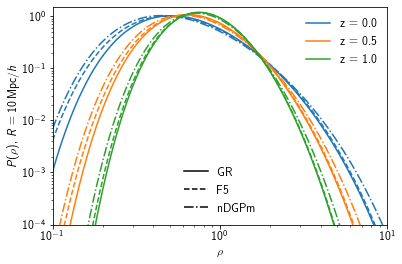

In [4]:
dNL_samples = np.logspace(-1,1,100)
plt.xlabel(r'$\rho$')
plt.ylabel(r'$P(\rho)$, $R = 10 \, {\rm Mpc}/h$')
plt.xlim(1e-1,10)
plt.ylim(1e-4,1.5)
plt.xscale('log')
plt.yscale('log')
line = [None for _ in range(len(z))]
for i in range(len(z)):
    line[i], = plt.plot(dNL_samples,pdf_gr_mat[0][i](dNL_samples), color='C'+str(i), label='z = '+str(z[i]))
    plt.plot(dNL_samples,pdf_fr_mat[0][i](dNL_samples), color='C'+str(i), linestyle='dashed')
    plt.plot(dNL_samples,pdf_dgp_mat[0][i](dNL_samples), color='C'+str(i), linestyle='dashdot')
z_legend = plt.legend(handles=line, loc="best", frameon=False)
ax = plt.gca().add_artist(z_legend)
gr_style, = plt.plot(dNL_samples,np.zeros(dNL_samples.shape), color='k', label='GR')
fr_style, = plt.plot(dNL_samples,np.zeros(dNL_samples.shape), color='k', linestyle='dashed', label=r'F5')
dgp_style, = plt.plot(dNL_samples,np.zeros(dNL_samples.shape), color='k', linestyle='dashdot', label='nDGPm')
plt.legend(handles=[gr_style,fr_style,dgp_style], loc='lower center', frameon=False)

# plt.savefig('/Users/matteoc/Documents/Projects/MG_PDF/codes/python_scripts/figures/gr_sc/test_pyLDT_z_evo.pdf', dpi=None, facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format=None,
#         transparent=False, bbox_inches='tight', pad_inches=0.1,
#         frameon=None, metadata=None)

plt.show()

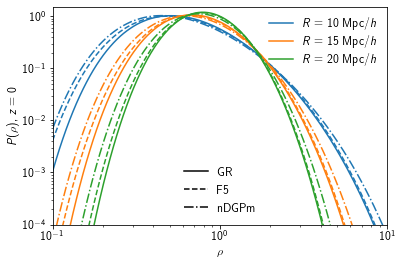

In [6]:
plt.xlabel(r'$\rho$')
plt.ylabel(r'$P(\rho)$, $z = 0$')
plt.xlim(1e-1,10)
plt.ylim(1e-4,1.5)
plt.xscale('log')
plt.yscale('log')
line = [None for _ in range(len(R))]
for i in range(len(R)):
    line[i], = plt.plot(dNL_samples,pdf_gr_mat[i][0](dNL_samples), color='C'+str(i), label=r'$R =$ '+str(int(R[i]))+r' Mpc/$h$')
    plt.plot(dNL_samples,pdf_fr_mat[i][0](dNL_samples), color='C'+str(i), linestyle='dashed')
    plt.plot(dNL_samples,pdf_dgp_mat[i][0](dNL_samples), color='C'+str(i), linestyle='dashdot')
R_legend = plt.legend(handles=line, loc='upper right', frameon=False)
ax = plt.gca().add_artist(R_legend)
gr_style, = plt.plot(dNL_samples,np.zeros(dNL_samples.shape), color='k', label='GR')
fr_style, = plt.plot(dNL_samples,np.zeros(dNL_samples.shape), color='k', linestyle='dashed', label=r'F5')
dgp_style, = plt.plot(dNL_samples,np.zeros(dNL_samples.shape), color='k', linestyle='dashdot', label='nDGPm')
plt.legend(handles=[gr_style,fr_style,dgp_style], loc='lower center', frameon=False)

# plt.savefig('/Users/matteoc/Documents/Projects/MG_PDF/codes/python_scripts/figures/gr_sc/test_pyLDT_R_evo.pdf', dpi=None, facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format=None,
#         transparent=False, bbox_inches='tight', pad_inches=0.1,
#         frameon=None, metadata=None)

plt.show()